In [9]:
import warnings
import os
import shutil
import random
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model


from keras.src.layers import BatchNormalization

from scipy.constants import hp

import keras_tuner as kt

In [10]:
#defining the directory of the dataset
blood_cancer_dir = "./Blood_Cancer_Dataset"

#defining the categories
categories = ["basophil", "erythroblast", "monocyte", "myeloblast", "seg_neutrophil"]

#defining paths of new directories
merged_dir = os.path.join(blood_cancer_dir, "merged")
train_dir = os.path.join(blood_cancer_dir, "Training")
test_dir = os.path.join(blood_cancer_dir, "Testing")

In [11]:
#creating the directories
os.makedirs(merged_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [12]:
#merging all images into merged
for category in categories:
    category_path = os.path.join(blood_cancer_dir, category)
    merged_category_path = os.path.join(merged_dir, category)

    # Ensure merged subfolders exist
    os.makedirs(merged_category_path, exist_ok=True)

    if os.path.exists(category_path):
        for img in os.listdir(category_path):
            img_path = os.path.join(category_path, img)

            if os.path.isfile(img_path):  # Ensure it's a file
                shutil.copy(img_path, os.path.join(merged_category_path, img))


print("All category images copied into the 'merged' folder.")

All category images copied into the 'merged' folder.


In [13]:
#splitting the data into training and testing
for category in categories:
    category_path = os.path.join(merged_dir, category)
    images = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]

    # Split dataset (80% training, 20% testing)
    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)

    # Create category subfolders inside Training & Testing
    train_category_path = os.path.join(train_dir, category)
    test_category_path = os.path.join(test_dir, category)
    os.makedirs(train_category_path, exist_ok=True)
    os.makedirs(test_category_path, exist_ok=True)

     # Move images to respective folders
    for img in train_imgs:
        shutil.move(os.path.join(category_path, img), os.path.join(train_category_path, img))

    for img in test_imgs:
        shutil.move(os.path.join(category_path, img), os.path.join(test_category_path, img))

print("Dataset successfully split into Training and Testing sets with category-wise organization!")

Dataset successfully split into Training and Testing sets with category-wise organization!


In [14]:
#function to count number of images in each directory based on categories
def count_total_images(directory):
    total_images = 0
    class_counts = {}

    for category in categories:
        class_path = os.path.join(directory, category)
        if os.path.exists(class_path):
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_counts[category] = num_images
            total_images += num_images
        else:
            class_counts[category] = 0

    return total_images, class_counts

total_train_images, train_counts = count_total_images(train_dir)
total_test_images, test_counts = count_total_images(test_dir)


print(f"Total Training Images: {total_train_images}")
print(f"Total Testing Images: {total_test_images}")
print("\nClass-wise distribution in Training Set:")
for category, count in train_counts.items():
    print(f"{category}: {count} images")

print("\nClass-wise distribution in Testing Set:")
for category, count in test_counts.items():
    print(f"{category}: {count} images")

Total Training Images: 4000
Total Testing Images: 1000

Class-wise distribution in Training Set:
basophil: 800 images
erythroblast: 800 images
monocyte: 800 images
myeloblast: 800 images
seg_neutrophil: 800 images

Class-wise distribution in Testing Set:
basophil: 200 images
erythroblast: 200 images
monocyte: 200 images
myeloblast: 200 images
seg_neutrophil: 200 images


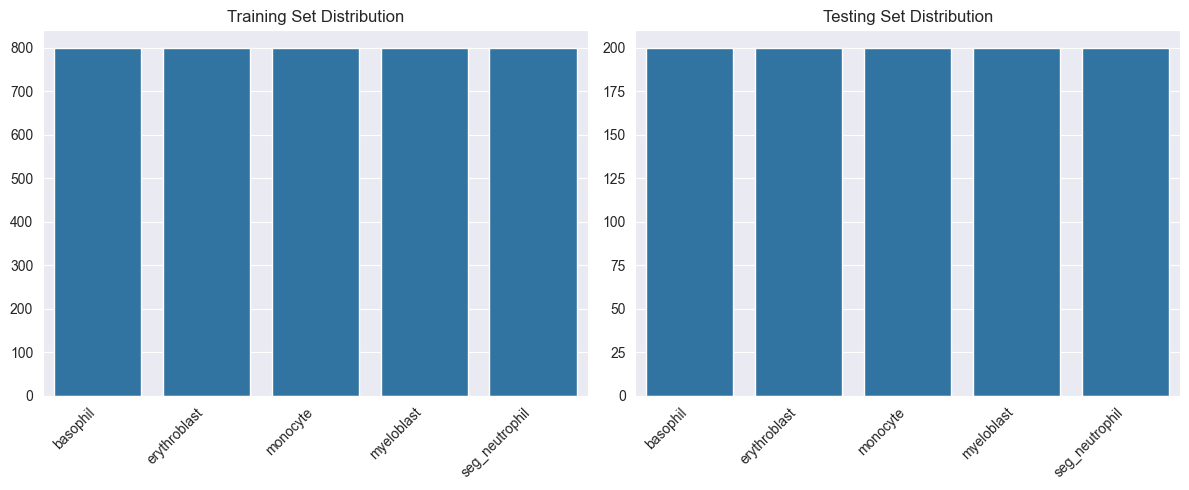

In [15]:
#visualizing the class distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

#training set distribution
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), ax=ax[0], width=0.8)
ax[0].set_title("Training Set Distribution")
ax[0].set_xticks(range(len(train_counts)))
ax[0].set_xticklabels(list(train_counts.keys()), rotation=45, ha="right")

#testing set distribution
sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), ax=ax[1], width=0.8)
ax[1].set_title("Testing Set Distribution")
ax[1].set_xticks(range(len(test_counts)))
ax[1].set_xticklabels(list(test_counts.keys()), rotation=45, ha="right")

plt.tight_layout()
plt.show()

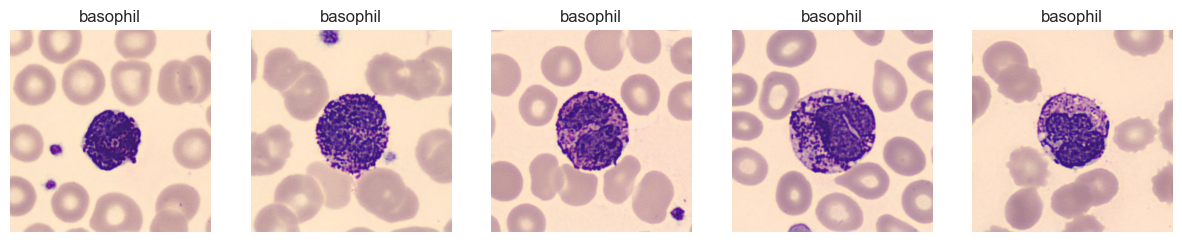

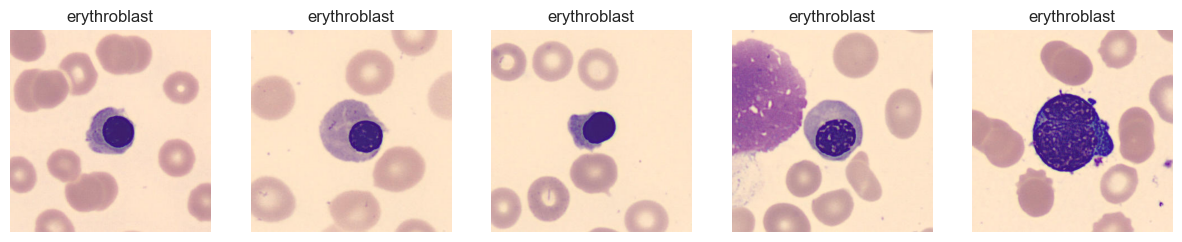

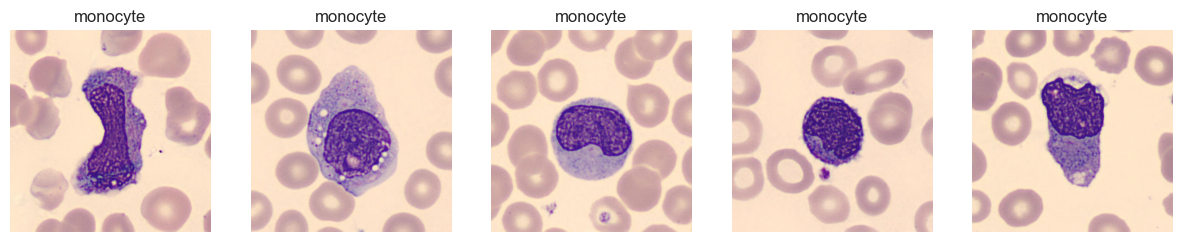

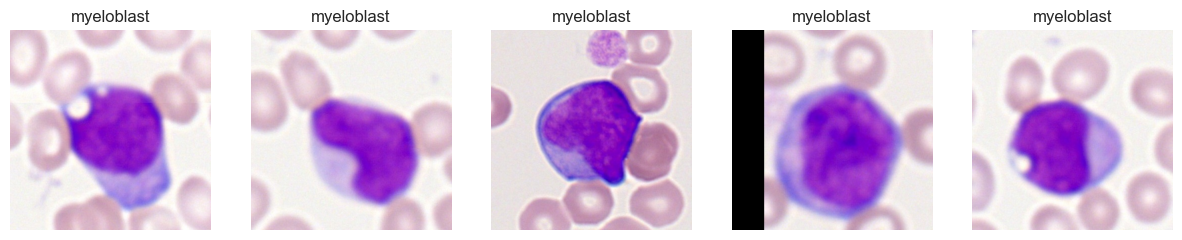

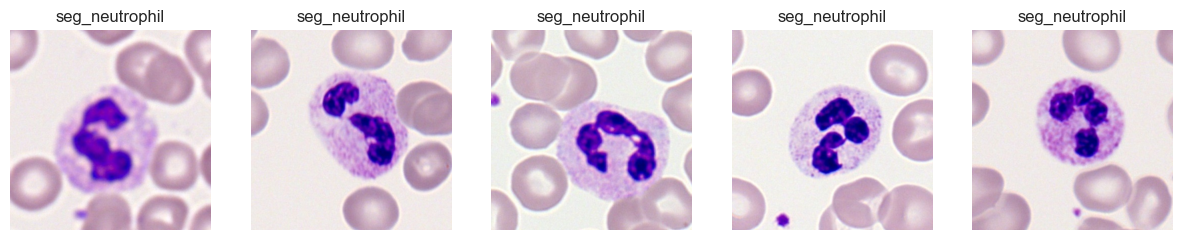

In [16]:
# Function to load and display sample images
def show_sample_images(directory, category):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    class_path = os.path.join(directory, category)
    images = os.listdir(class_path)[:5]

    for i, img_name in enumerate(images):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(category)
    plt.show()

#displaying random images from each category
for category in categories:
    show_sample_images(train_dir, category)

In [17]:
#processing the image
img_size = (224, 224)

#preprocessing the images with respect to size. Also performing normalization on the images and converting it to NumpyArrays
def preprocess_images(directory):
    data = []
    labels = []

    #used to encode the category labels to numerical values
    for category in categories:
        class_path = os.path.join(directory, category)
        label = categories.index(category)

        #read and preprocess each image in the category folder
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)  # Resize to 224x224

            data.append(img)
            labels.append(label)

    data = np.array(data) / 255.0  # Normalize images
    labels = np.array(labels)

    return data, labels

In [18]:
#loading the training and testing Data
X_train, y_train = preprocess_images(train_dir)
X_test, y_test = preprocess_images(test_dir)

print("Data Preprocessing Completed!")
print(f"Training Data Shape: {X_train.shape}, Testing Data Shape: {X_test.shape}")



Data Preprocessing Completed!
Training Data Shape: (4000, 224, 224, 3), Testing Data Shape: (1000, 224, 224, 3)


In [19]:
# Ensure dataset is loaded & flattened
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)



In [20]:
# Step 1: Apply PCA (Retain 95% Variance)
pca = PCA(n_components=0.95)  # Faster computation for large datasets
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

In [21]:
# Step 2: Apply SelectKBest (Select Top 500 Features)
k_best = min(500, X_train_pca.shape[1])  # Prevents errors if PCA reduces features below 500
selector = SelectKBest(score_func=f_classif, k=k_best)
X_train_selected = selector.fit_transform(X_train_pca, y_train)
X_test_selected = selector.transform(X_test_pca)

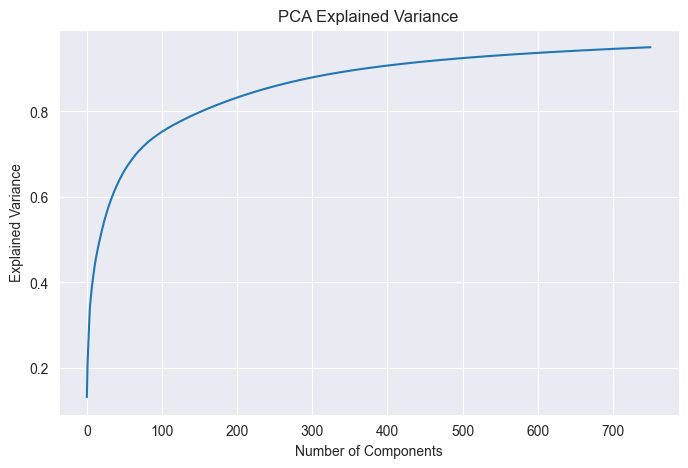

In [22]:
# Display PCA Explained Variance Ratio
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

In [23]:
# Display Shape of Selected Features
print(f"Original Shape: {X_train_flat.shape}")
print(f"PCA Transformed Shape: {X_train_pca.shape}")
print(f"Selected Features Shape: {X_train_selected.shape}")

Original Shape: (4000, 150528)
PCA Transformed Shape: (4000, 751)
Selected Features Shape: (4000, 500)


In [25]:
#converting labels to categorical (one-hot encoding)
y_train_categorical = to_categorical(y_train, num_classes=len(categories))
y_test_categorical = to_categorical(y_test, num_classes=len(categories))

In [26]:
# This code initializes an ImageDataGenerator for data augmentation.
# It applies random rotations (up to 20 degrees), width and height shifts (up to 20%),
# and horizontal flipping to enhance model generalization without excessive augmentation.

datagen = ImageDataGenerator(
    rotation_range=20,  # Less aggressive rotation
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True  # Only flipping, no zoom or extra augmentation
)


In [27]:
#defining the CNN model
cnn_model = Sequential([
    Input(shape=(224, 224, 3)),  # Explicit input layer

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(len(categories), activation='softmax')
])


In [28]:
# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [33]:
# training the CNN Model
history = cnn_model.fit(X_train, y_train_categorical,
                        epochs=20,  # Adjust as needed
                        batch_size=16,
                        validation_data=(X_test, y_test_categorical))

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step - accuracy: 0.9442 - loss: 0.1716 - val_accuracy: 0.5910 - val_loss: 66.3587
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 0.9528 - loss: 0.1858 - val_accuracy: 0.9300 - val_loss: 0.2894
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 479s 2s/step - accuracy: 0.9453 - loss: 0.3286 - val_accuracy: 0.7230 - val_loss: 3.0083
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 461s 2s/step - accuracy: 0.9456 - loss: 0.2518 - val_accuracy: 0.6610 - val_loss: 74.5417
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 470s 2s/step - accuracy: 0.9288 - loss: 0.3361 - val_accuracy: 0.9420 - val_loss: 0.2399
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 556s 2s/step - accuracy: 0.9277 - loss: 0.2283 - val_accuracy: 0.6530 - val_loss: 64.3055
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 526s 2s/step - accuracy: 0.9255 - loss: 0.3092 - val_accuracy: 0.5660 - val_loss: 14.9751
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - accuracy: 0.9448 - loss: 0.2681 - val_

In [34]:
cnn_model.save("blood_cancer_cnn_model.keras")
print("Best Accuracy Model saved successfully!")

Best Accuracy Model saved successfully!


In [35]:
cnn_model = load_model("blood_cancer_cnn_model.keras")

In [36]:
# Evaluate CNN model
test_loss, test_acc = cnn_model.evaluate(X_test, y_test_categorical)
print(f"✅ CNN Test Accuracy: {test_acc:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 721ms/step - accuracy: 0.9723 - loss: 0.1080
✅ CNN Test Accuracy: 0.9670


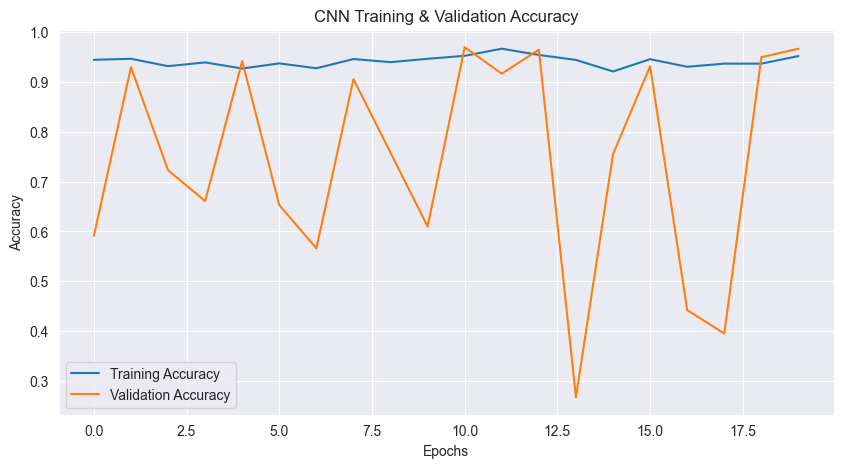

In [37]:
# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Training & Validation Accuracy')
plt.legend()
plt.show()

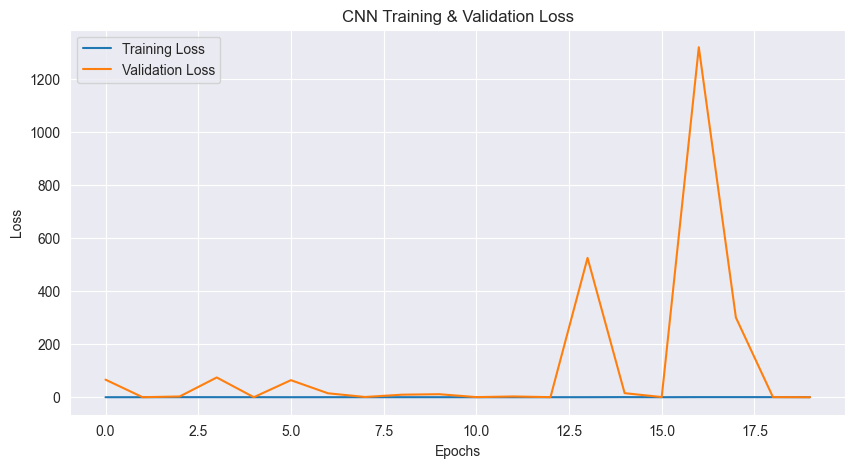

In [38]:
# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Training & Validation Loss')
plt.legend()
plt.show()

In [39]:
cnn_model.save("blood_cancer_cnn_model.keras")  # ✅ Saves using the new Keras format
print("✅ Model saved successfully in the new .keras format!")


✅ Model saved successfully in the new .keras format!


In [40]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 173056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    44,302,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,027,665 (511.27 MB)

 Trainable params: 44,675,589 (170.42 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 89,351,180 (340.85 MB)

In [41]:
# Step 1: Make Predictions
y_pred_probs = cnn_model.predict(X_test)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test_categorical, axis=1)  # Get true labels

32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 738ms/step


In [43]:
# Step 2: Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

In [44]:
# Step 3: Calculate Precision Score
precision = precision_score(y_true, y_pred, average='weighted')

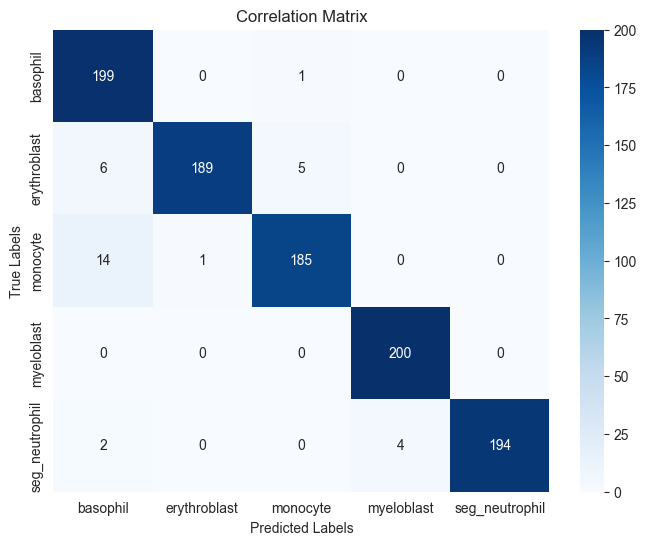

In [45]:
# Step 4: Visualizing the Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Correlation Matrix')
plt.show()

In [46]:
# Step 5: Print Precision Score and Classification Report
print(f"Precision Score: {precision:.4f}")
print("\n Classification Report:\n", classification_report(y_true, y_pred, target_names=categories))

Precision Score: 0.9688

 Classification Report:
                 precision    recall  f1-score   support

      basophil       0.90      0.99      0.95       200
  erythroblast       0.99      0.94      0.97       200
      monocyte       0.97      0.93      0.95       200
    myeloblast       0.98      1.00      0.99       200
seg_neutrophil       1.00      0.97      0.98       200

      accuracy                           0.97      1000
     macro avg       0.97      0.97      0.97      1000
  weighted avg       0.97      0.97      0.97      1000

